In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
clean_df = pd.read_csv('clean_df_1Mar2024.csv')

In [3]:
# def categorize_age(age):
#     if age < 18:
#         return 0  # Category for minors
#     elif age <= 64:
#         return 1  # Category for adults
#     else:
#         return 2  # Category for seniors

# # Column for age categories
# clean_df['Vict_Age_Category'] = clean_df['Vict_Age'].apply(categorize_age)

In [4]:
data=clean_df

# Convert 'Date_Rptd' and 'DATE_OCC' to datetime
data['Date_Rptd'] = pd.to_datetime(data['Date_Rptd'], format='%m/%d/%Y %I:%M:%S %p')
data['DATE_OCC'] = pd.to_datetime(data['DATE_OCC'], format='%Y-%m-%d')


# Extract day of week, month, and year from 'DATE_OCC'
data['Day_of_Week'] = data['DATE_OCC'].dt.dayofweek
data['Month'] = data['DATE_OCC'].dt.month
data['Year'] = data['DATE_OCC'].dt.year

# Drop the original 'Date_Rptd' and 'DATE_OCC' columns
data = data.drop(['Date_Rptd', 'DATE_OCC'], axis=1)

# Convert 'Vict_Sex' and 'Vict_Descent' to dummy variables
categorical_to_convert = ['Vict_Sex', 'Region_Ethnic_Origin', 'AREA'] #, 'Vict_Age_Category']
data = pd.get_dummies(data, columns=categorical_to_convert, drop_first=True)
data['Day_of_Week'] = data['Day_of_Week'].astype('category')
data['Month'] = data['Month'].astype('category')
data['Year'] = data['Year'].astype('category')

# Create dummy variables for these columns
data = pd.get_dummies(data, columns=['Day_of_Week', 'Month', 'Year'], drop_first=True)


# We will not convert 'LOCATION' due to its high cardinality
data.drop(['LOCATION', 'Vict_Descent', 'DR_NO'], axis=1, inplace=True)

In [6]:
data = data.drop(columns=['Crm_Cd_Desc', 'Crime_Category', 'Crm_Cd', 'AREA_NAME', 'Rpt_Dist_No', 'TIME_OCC'], axis = 0)

In [7]:
data.columns

Index(['Part_1-2', 'Vict_Age', 'LAT', 'LON', 'Avg_Temp', 'Avg_Dewpoint',
       'Avg_Humidity', 'Avg_Windspeed', 'Avg_Pressure', 'Total_Precipitation',
       'Crime_Category_Code', 'Weapon_Reported', 'Vict_Sex_M', 'Vict_Sex_X',
       'Region_Ethnic_Origin_Black',
       'Region_Ethnic_Origin_Hispanic/Latin/Mexican',
       'Region_Ethnic_Origin_Other', 'Region_Ethnic_Origin_Unknown',
       'Region_Ethnic_Origin_White', 'AREA_2', 'AREA_3', 'AREA_4', 'AREA_5',
       'AREA_6', 'AREA_7', 'AREA_8', 'AREA_9', 'AREA_10', 'AREA_11', 'AREA_12',
       'AREA_13', 'AREA_14', 'AREA_15', 'AREA_16', 'AREA_17', 'AREA_18',
       'AREA_19', 'AREA_20', 'AREA_21', 'Day_of_Week_1', 'Day_of_Week_2',
       'Day_of_Week_3', 'Day_of_Week_4', 'Day_of_Week_5', 'Day_of_Week_6',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12', 'Year_2011',
       'Year_2012', 'Year_2013', 'Year_2014', 'Year_2015', 'Year_2016',
       'Y

In [8]:
class_counts = data['Crime_Category_Code'].value_counts()
print("Class counts before downsampling:\n", class_counts)

# Find the number of instances in the smallest class
smallest_class_size = class_counts.min()

# Create a DataFrame to hold the downsampled data
downsampled_data = pd.DataFrame()

# Loop over each class and downsample
for category in class_counts.index:
    category_subset = data[data['Crime_Category_Code'] == category]
    
    # Sample the current category to match the smallest class size
    category_subset_downsampled = category_subset.sample(n=smallest_class_size, random_state=42)
    
    # Append the downsampled subset to the downsampled_data DataFrame
    downsampled_data = pd.concat([downsampled_data, category_subset_downsampled])

# Shuffle the downsampled dataset to mix the classes
data = downsampled_data.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nAfter downsampling:")
print(data['Crime_Category_Code'].value_counts())

Class counts before downsampling:
 Crime_Category_Code
5    935482
0    718361
2    459196
6    271307
1    207471
3    131321
7     93217
4     67447
Name: count, dtype: int64

After downsampling:
Crime_Category_Code
6    67447
5    67447
2    67447
4    67447
7    67447
3    67447
1    67447
0    67447
Name: count, dtype: int64


In [9]:
X_xgb_full = data.drop('Crime_Category_Code', axis=1)  # Features
y_xgb_full = data['Crime_Category_Code']

In [10]:
X_xgb_full_train, X_xgb_full_test, y_xgb_full_train, y_xgb_full_test = train_test_split(X_xgb_full, y_xgb_full, test_size=0.2, random_state=42)

In [11]:
xgb_full_model = XGBClassifier(n_estimators = 100, n_jobs=-1, use_label_encoder = False, eval_metric = 'mlogloss')

In [12]:
xgb_full_model.fit(X_xgb_full_train,  y_xgb_full_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)

Accuracy: 0.6117
              precision    recall  f1-score   support

           0       0.74      0.69      0.71     13520
           1       0.42      0.60      0.49     13527
           2       0.94      0.65      0.77     13523
           3       0.70      0.87      0.77     13480
           4       0.57      0.41      0.48     13438
           5       0.81      0.92      0.86     13201
           6       0.40      0.32      0.36     13565
           7       0.42      0.45      0.44     13662

    accuracy                           0.61    107916
   macro avg       0.63      0.61      0.61    107916
weighted avg       0.62      0.61      0.61    107916



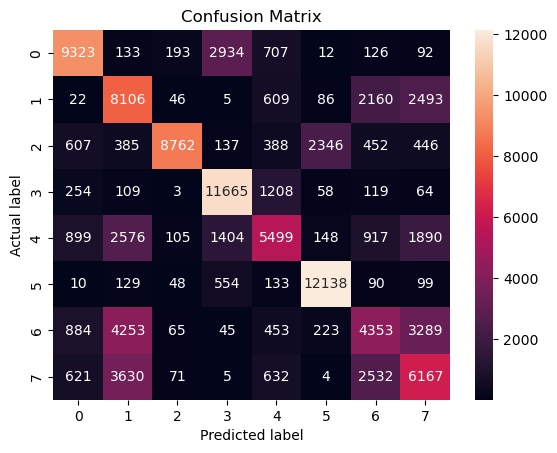

In [13]:
y_pred = xgb_full_model.predict(X_xgb_full_test)

# Accuracy
accuracy = accuracy_score(y_xgb_full_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print(classification_report(y_xgb_full_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_xgb_full_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [14]:
X_xgb_wo_victim = data.drop(['Crime_Category_Code', 'Vict_Sex_M', 'Vict_Sex_X', 'Region_Ethnic_Origin_Black',
       'Region_Ethnic_Origin_Hispanic/Latin/Mexican',
       'Region_Ethnic_Origin_Other', 'Region_Ethnic_Origin_Unknown',
       'Region_Ethnic_Origin_White'], axis=1)  # Features
y_xgb_wo_victim = data['Crime_Category_Code']

In [15]:
X_xgb_wo_victim_train, X_xgb_wo_victim_test, y_xgb_wo_victim_train, y_xgb_wo_victim_test = train_test_split(X_xgb_wo_victim, y_xgb_wo_victim, test_size=0.2, random_state=42)

In [16]:
xgb_wo_victim_model = XGBClassifier(n_estimators = 100, n_jobs=-1, use_label_encoder = False, eval_metric = 'mlogloss')

In [17]:
xgb_wo_victim_model.fit(X_xgb_wo_victim_train,  y_xgb_wo_victim_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)

Accuracy: 0.5764
              precision    recall  f1-score   support

           0       0.73      0.69      0.71     13520
           1       0.40      0.63      0.49     13527
           2       0.80      0.65      0.72     13523
           3       0.62      0.92      0.75     13480
           4       0.60      0.22      0.33     13438
           5       0.79      0.80      0.80     13201
           6       0.37      0.31      0.34     13565
           7       0.41      0.39      0.40     13662

    accuracy                           0.58    107916
   macro avg       0.59      0.58      0.56    107916
weighted avg       0.59      0.58      0.56    107916



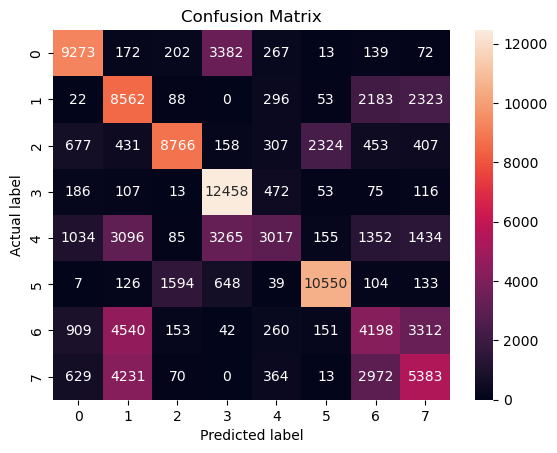

In [18]:
y_pred_wo_victim = xgb_wo_victim_model.predict(X_xgb_wo_victim_test)

# Accuracy
accuracy = accuracy_score(y_xgb_wo_victim_test, y_pred_wo_victim)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print(classification_report(y_xgb_wo_victim_test, y_pred_wo_victim))

# Confusion Matrix
cm = confusion_matrix(y_xgb_wo_victim_test, y_pred_wo_victim)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [19]:
X_xgb_wo_weather = data.drop(['Crime_Category_Code', 'Avg_Temp',
       'Avg_Dewpoint', 'Avg_Humidity', 'Avg_Windspeed', 'Avg_Pressure',
       'Total_Precipitation'], axis=1) 
y_xgb_wo_weather = data['Crime_Category_Code']

In [20]:
X_xgb_wo_weather_train, X_xgb_wo_weather_test, y_xgb_wo_weather_train, y_xgb_wo_weather_test = train_test_split(X_xgb_wo_weather, y_xgb_wo_weather, test_size=0.2, random_state=42)

In [21]:
xgb_wo_weather_model = XGBClassifier(n_estimators = 100, n_jobs=-1, use_label_encoder = False, eval_metric = 'mlogloss')

In [22]:
xgb_wo_weather_model.fit(X_xgb_wo_weather_train,  y_xgb_wo_weather_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)

Accuracy: 0.6099
              precision    recall  f1-score   support

           0       0.74      0.69      0.71     13520
           1       0.41      0.60      0.48     13527
           2       0.94      0.65      0.77     13523
           3       0.70      0.87      0.77     13480
           4       0.57      0.41      0.48     13438
           5       0.81      0.92      0.86     13201
           6       0.41      0.31      0.35     13565
           7       0.43      0.44      0.43     13662

    accuracy                           0.61    107916
   macro avg       0.63      0.61      0.61    107916
weighted avg       0.62      0.61      0.61    107916



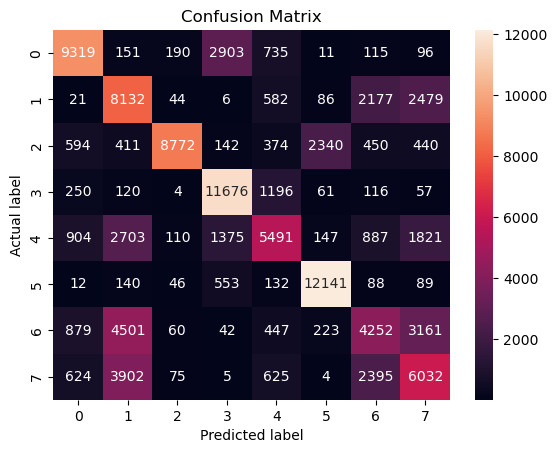

In [23]:
y_pred_wo_weather = xgb_wo_weather_model.predict(X_xgb_wo_weather_test)

# Accuracy
accuracy = accuracy_score(y_xgb_wo_weather_test, y_pred_wo_weather)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print(classification_report(y_xgb_wo_weather_test, y_pred_wo_weather))

# Confusion Matrix
cm = confusion_matrix(y_xgb_wo_weather_test, y_pred_wo_weather)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [24]:
X_xgb_wo_weathervictim = data.drop(['Crime_Category_Code', 'Vict_Sex_M', 'Vict_Sex_X', 'Region_Ethnic_Origin_Black',
       'Region_Ethnic_Origin_Hispanic/Latin/Mexican',
       'Region_Ethnic_Origin_Other', 'Region_Ethnic_Origin_Unknown',
       'Region_Ethnic_Origin_White', 'Crime_Category_Code', 'Avg_Temp',
       'Avg_Dewpoint', 'Avg_Humidity', 'Avg_Windspeed', 'Avg_Pressure',
       'Total_Precipitation'], axis=1)  # Features

y_xgb_wo_weathervictim = data['Crime_Category_Code']

In [25]:
X_xgb_wo_weathervictim_train, X_xgb_wo_weathervictim_test, y_xgb_wo_weathervictim_train, y_xgb_wo_weathervictim_test = train_test_split(X_xgb_wo_weathervictim, y_xgb_wo_weathervictim, test_size=0.2, random_state=42)

In [26]:
xgb_wo_weathervictim_model = XGBClassifier(n_estimators = 100, n_jobs=-1, use_label_encoder = False, eval_metric = 'mlogloss')

In [27]:
xgb_wo_weathervictim_model.fit(X_xgb_wo_weathervictim_train,  y_xgb_wo_weathervictim_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)

Accuracy: 0.5735
              precision    recall  f1-score   support

           0       0.73      0.68      0.70     13520
           1       0.39      0.64      0.48     13527
           2       0.80      0.65      0.72     13523
           3       0.62      0.92      0.75     13480
           4       0.60      0.22      0.32     13438
           5       0.79      0.80      0.80     13201
           6       0.37      0.29      0.32     13565
           7       0.41      0.39      0.40     13662

    accuracy                           0.57    107916
   macro avg       0.59      0.57      0.56    107916
weighted avg       0.59      0.57      0.56    107916



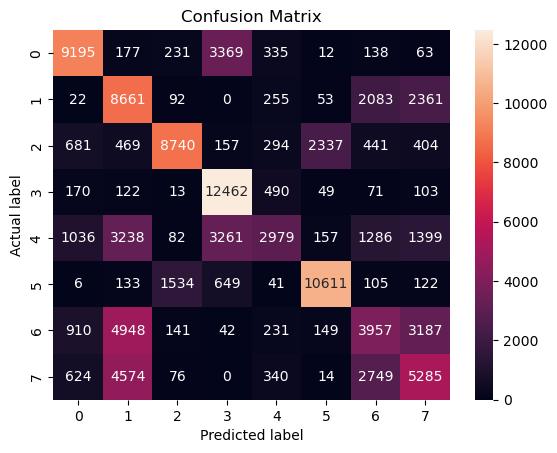

In [28]:
y_pred_wo_weathervictim = xgb_wo_weathervictim_model.predict(X_xgb_wo_weathervictim_test)

# Accuracy
accuracy = accuracy_score(y_xgb_wo_weathervictim_test, y_pred_wo_weathervictim)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print(classification_report(y_xgb_wo_weathervictim_test, y_pred_wo_weathervictim))

# Confusion Matrix
cm = confusion_matrix(y_xgb_wo_weathervictim_test, y_pred_wo_weathervictim)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

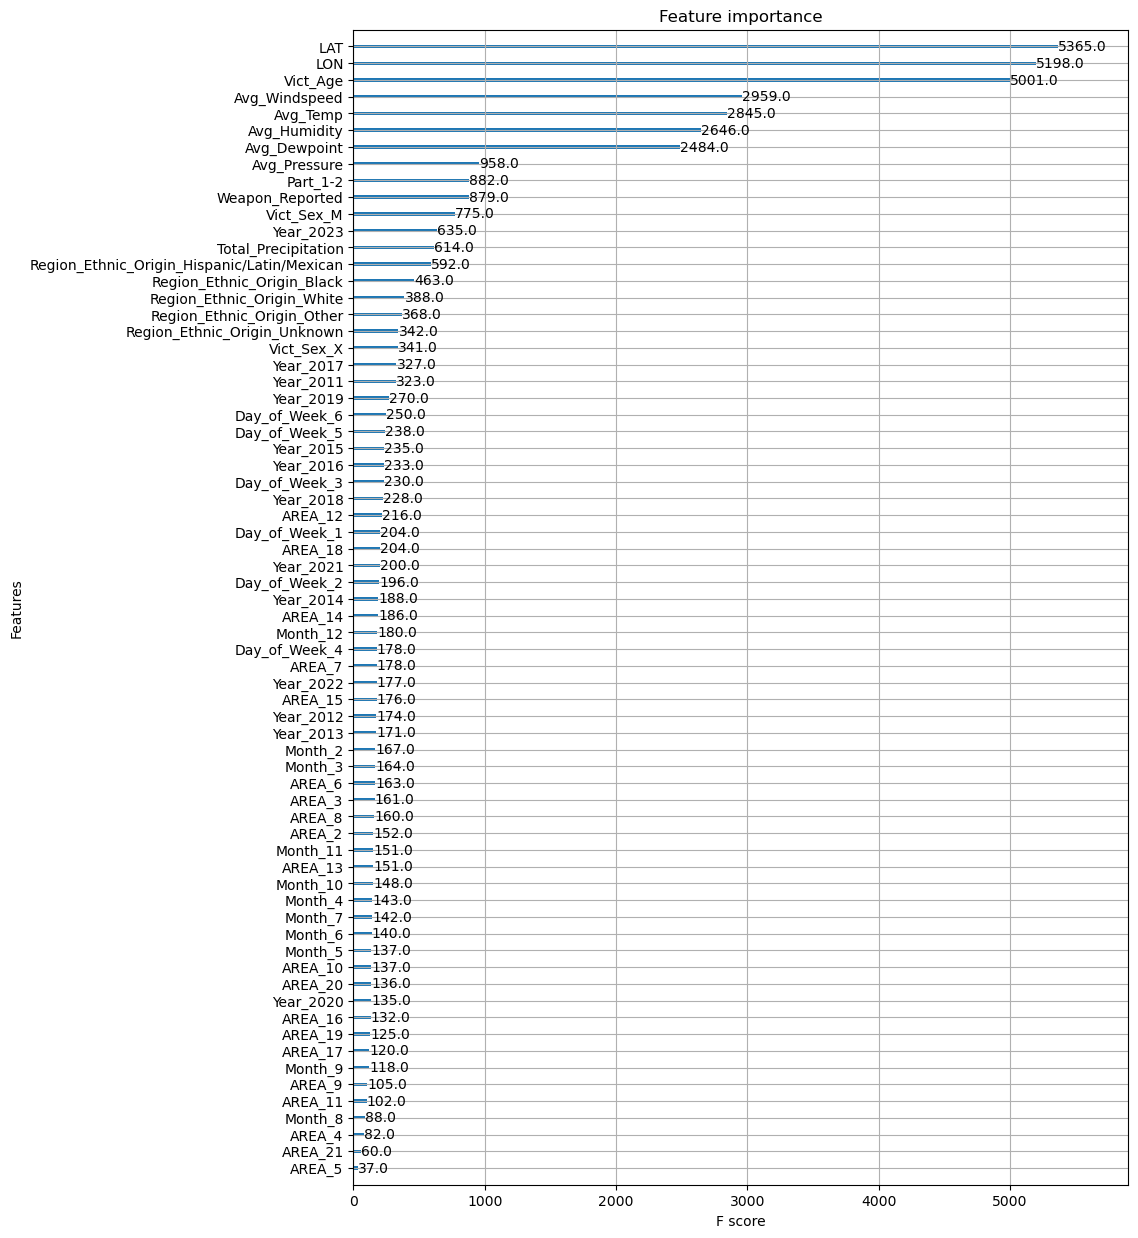

In [29]:
import xgboost as xgb

xgb.plot_importance(xgb_full_model)
plt.gcf().set_size_inches(10, 15) 
plt.show()

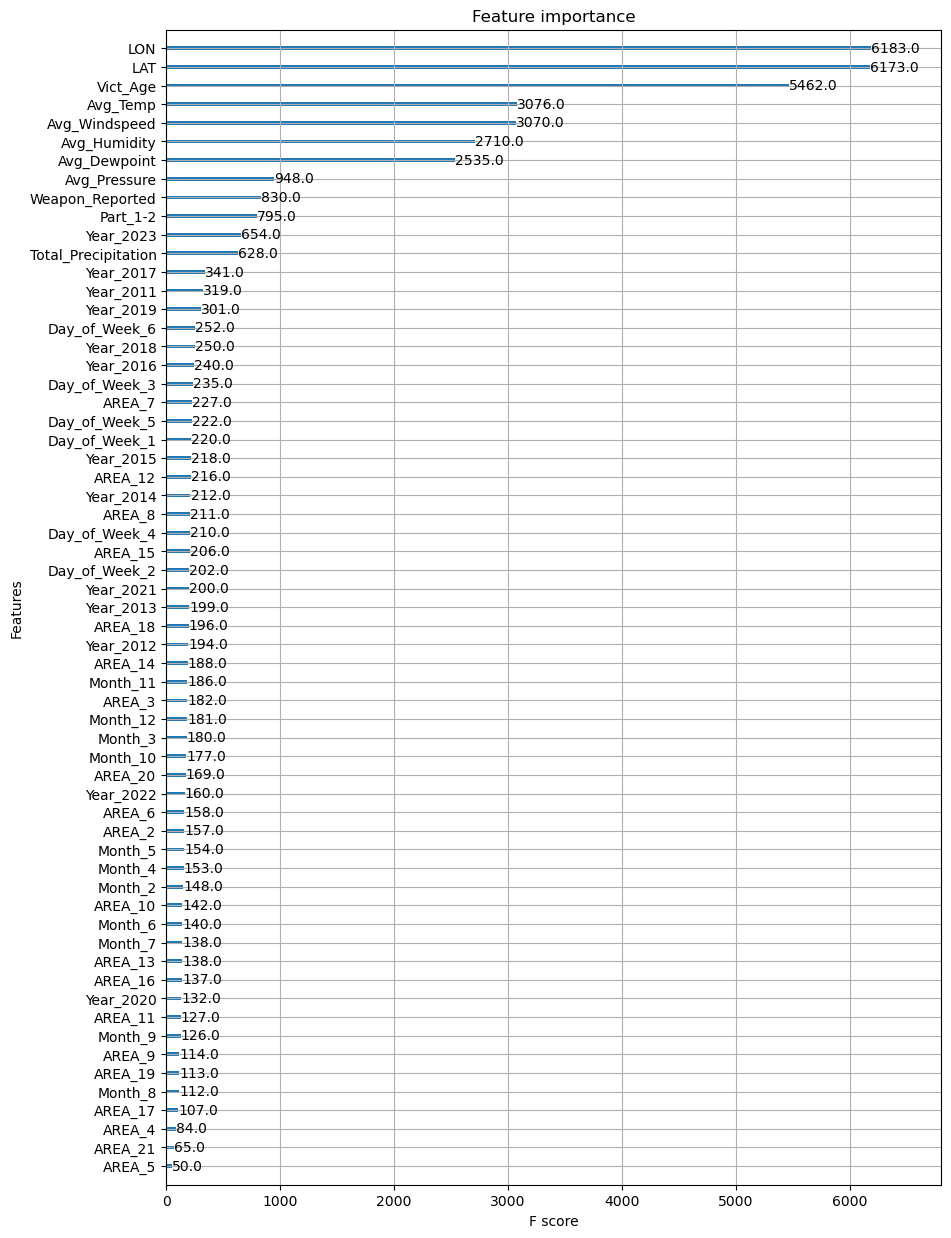

In [30]:
xgb.plot_importance(xgb_wo_victim_model)
plt.gcf().set_size_inches(10, 15) 
plt.show()

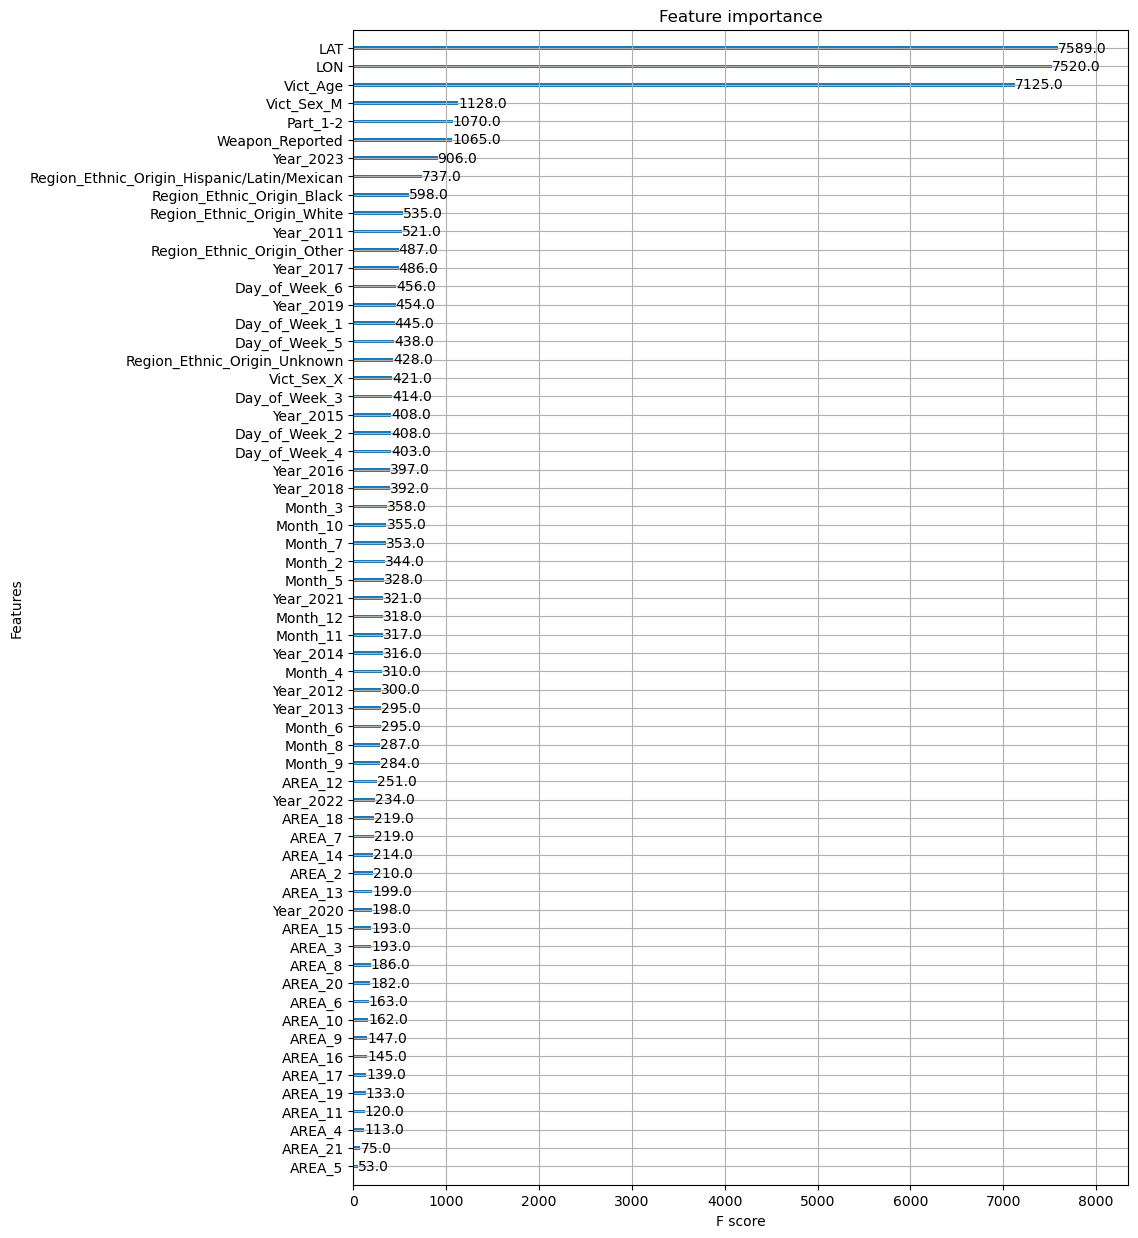

In [31]:
xgb.plot_importance(xgb_wo_weather_model)
plt.gcf().set_size_inches(10, 15) 
plt.show()

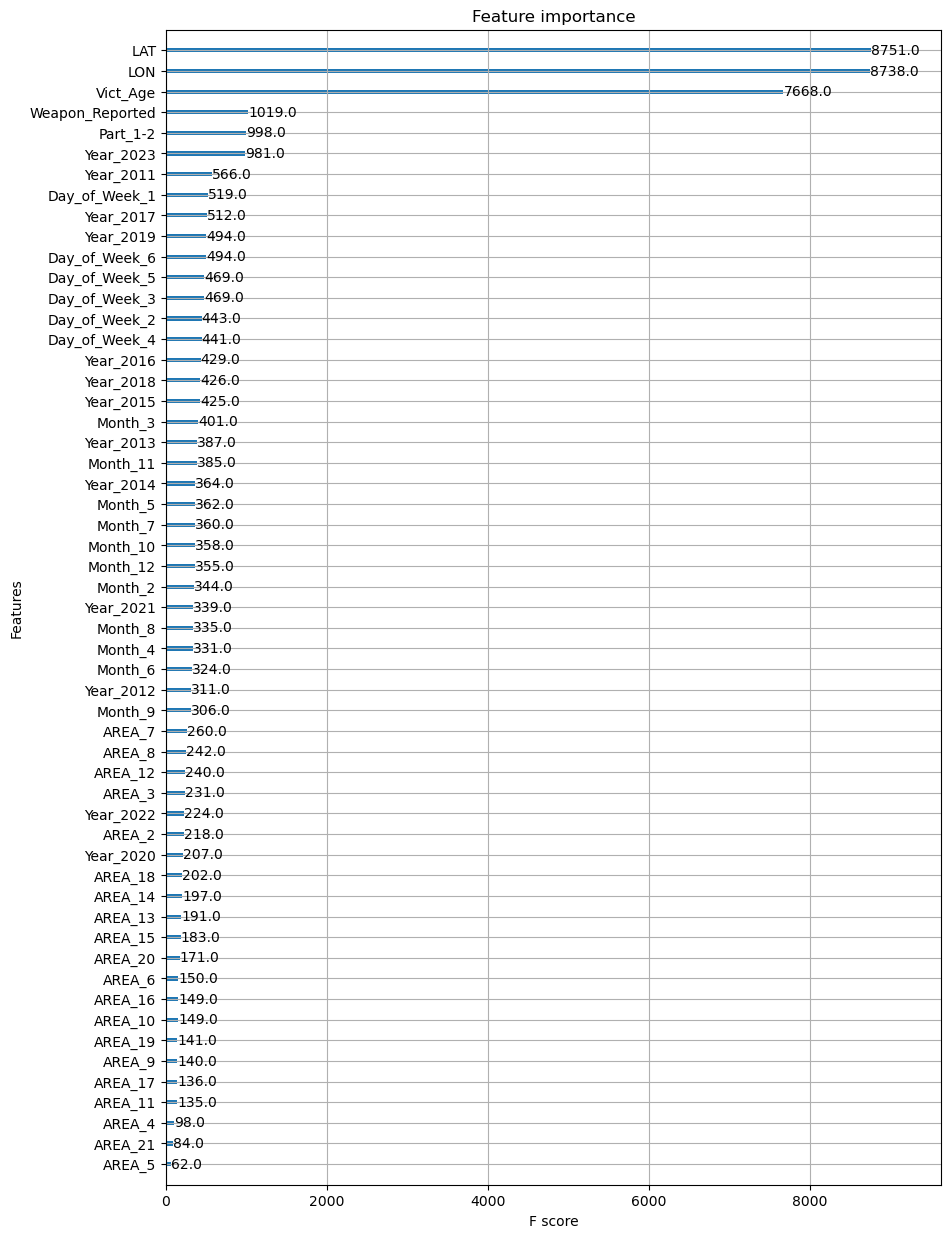

In [32]:
xgb.plot_importance(xgb_wo_weathervictim_model)
plt.gcf().set_size_inches(10, 15) 
plt.show()